In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import collect_set,col
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.utils.data as td
import torch.nn.functional as F

In [0]:
!pip install torch

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 933.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 941.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.1 MB/s eta 0:00:00
     ━━━━

In [0]:
 %sh
 rm -r /dbfs/deepml_lab
 mkdir /dbfs/deepml_lab
 wget -O /dbfs/deepml_lab/penguins.csv https://raw.githubusercontent.com/MicrosoftLearning/mslearn-databricks/main/data/penguins.csv

rm: cannot remove '/dbfs/deepml_lab': No such file or directory
--2024-07-01 02:33:52--  https://raw.githubusercontent.com/MicrosoftLearning/mslearn-databricks/main/data/penguins.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9533 (9.3K) [text/plain]
Saving to: ‘/dbfs/deepml_lab/penguins.csv’

     0K .........                                             100% 1.67M=0.005s

2024-07-01 02:33:52 (1.67 MB/s) - ‘/dbfs/deepml_lab/penguins.csv’ saved [9533/9533]



In [0]:
dbutils.fs.ls("dbfs:/deepml_lab/")

[FileInfo(path='dbfs:/deepml_lab/penguins.csv', name='penguins.csv', size=9533, modificationTime=1719801232000)]

In [0]:
df = spark.read.format("csv").option("header", "true").load("/deepml_lab/penguins.csv").dropna()

In [0]:
display(df.limit(10))

Island,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
Torgersen,39.1,18.7,181,3750,0
Torgersen,39.5,17.4,186,3800,0
Torgersen,40.3,18,195,3250,0
Torgersen,36.7,19.3,193,3450,0
Torgersen,39.3,20.6,190,3650,0
Torgersen,38.9,17.8,181,3625,0
Torgersen,39.2,19.6,195,4675,0
Torgersen,34.1,18.1,193,3475,0
Torgersen,42,20.2,190,4250,0
Torgersen,37.8,17.1,186,3300,0


In [0]:
#  Encode the Island with a simple integer index
# Scale FlipperLength and BodyMass so they're on a similar scale to the bill measurements

islands = df.select(collect_set("Island").alias('Islands')).first()['Islands']
island_indexes = [(islands[i], i) for i in range(0, len(islands))]

In [0]:
display(df.select(collect_set("Island").alias('Islands')).first())

Row(Islands=['Dream', 'Torgersen', 'Biscoe'])

In [0]:
islands

['Dream', 'Torgersen', 'Biscoe']

In [0]:
island_indexes[:5]

[('Dream', 0), ('Torgersen', 1), ('Biscoe', 2)]

In [0]:
df_indexes = spark.createDataFrame(island_indexes).toDF('Island', 'IslandIdx')

In [0]:
display(input=df_indexes)

Island,IslandIdx
Dream,0
Torgersen,1
Biscoe,2


In [0]:

data = df.join(other=df_indexes, on=['Island'], how='left').select(col("IslandIdx"),
                   col("CulmenLength").astype("float"),
                   col("CulmenDepth").astype("float"),
                   (col("FlipperLength").astype("float")/10).alias("FlipperScaled"),
                    (col("BodyMass").astype("float")/100).alias("MassScaled"),
                   col("Species").astype("int")
                    )

In [0]:
# Oversample the dataframe to triple its size
# (Deep learning techniques like LOTS of data)
for i in range(1,3):
    data = data.union(other=data)

In [0]:
# Split the data into training and testing datasets   
features = ['IslandIdx','CulmenLength','CulmenDepth','FlipperScaled','MassScaled']
label = 'Species'

In [0]:
x_train, x_test, y_train, y_test = train_test_split(data.toPandas()[features].values,
                                                    data.toPandas()[label].values,
                                                    test_size=0.30,
                                                    random_state=0)

In [0]:
print (f'Training Set:{len(x_train)} rows, Test Set: {len(x_test)} rows' )

Training Set:957 rows, Test Set: 411 rows


In [0]:
# Set random seed for reproducability
torch.manual_seed(0)
   
print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.3.1+cu121


In [0]:
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=20,
    shuffle=False, num_workers=1)

In [0]:
# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=20,
                             shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [0]:
# Number of hidden layer nodes
hl = 10
   
# Define the neural network
class PenguinNet(nn.Module):
    def __init__(self):
        super(PenguinNet, self).__init__()
        self.fc1 = nn.Linear(len(features), hl)
        self.fc2 = nn.Linear(hl, hl)
        self.fc3 = nn.Linear(hl, 3)
   
    def forward(self, x):
        fc1_output = torch.relu(self.fc1(x))
        fc2_output = torch.relu(self.fc2(fc1_output))
        y = F.log_softmax(self.fc3(fc2_output).float(), dim=1)
        return y
   
# Create a model instance from the network
model = PenguinNet()
print(model)

PenguinNet(
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


In [0]:
def train(model, data_loader, optimizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Set the model to training mode
    model.train()
    train_loss = 0
       
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        train_loss += loss.item()
   
        # backpropagate adjustments to the weights
        loss.backward()
        optimizer.step()
   
    #Return average loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [0]:
def test(model, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0
   
    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)
   
            # calculate the loss
            test_loss += loss_criteria(out, target).item()
   
            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()
               
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
       
    # return average loss for the epoch
    return avg_loss

### Train a Model

In [0]:
loss_criteria = nn.CrossEntropyLoss()
   
# Use an optimizer to adjust weights and reduce loss
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
   
# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
   
# Train over 100 epochs
epochs = 100
for epoch in range(1, epochs + 1):
   
    # print the epoch number
    print('Epoch: {}'.format(epoch))
       
    # Feed training data into the model
    train_loss = train(model=model,data_loader=train_loader, optimizer=optimizer)
       
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
       
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set: Average loss: 0.887707
Validation set: Average loss: 0.754690, Accuracy: 377/411 (92%)

Epoch: 2
Training set: Average loss: 0.662605
Validation set: Average loss: 0.615731, Accuracy: 375/411 (91%)

Epoch: 3
Training set: Average loss: 0.542340
Validation set: Average loss: 0.503344, Accuracy: 391/411 (95%)

Epoch: 4
Training set: Average loss: 0.427001
Validation set: Average loss: 0.384497, Accuracy: 398/411 (97%)

Epoch: 5
Training set: Average loss: 0.316318
Validation set: Average loss: 0.276599, Accuracy: 401/411 (98%)

Epoch: 6
Training set: Average loss: 0.226592
Validation set: Average loss: 0.198076, Accuracy: 404/411 (98%)

Epoch: 7
Training set: Average loss: 0.164717
Validation set: Average loss: 0.146443, Accuracy: 404/411 (98%)

Epoch: 8
Training set: Average loss: 0.125291
Validation set: Average loss: 0.114000, Accuracy: 407/411 (99%)

Epoch: 9
Training set: Average loss: 0.100009
Validation set: Average loss: 0.092466, Accuracy: 407/411 (99%)

E

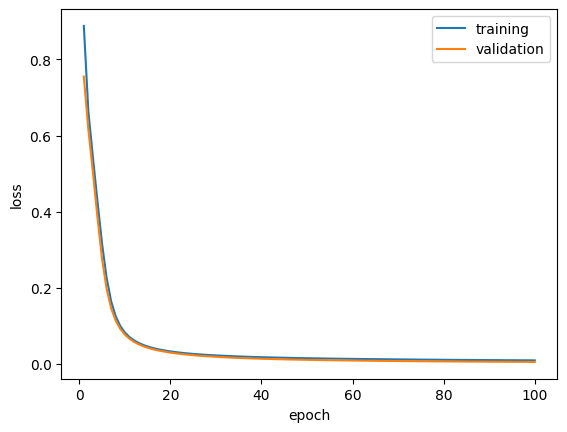

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
   
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### View the Layers in your trained model

In [0]:
for paramTensor in model.state_dict():
  print(paramTensor,"\n",model.state_dict()[paramTensor].numpy())

fc1.weight 
 [[-3.3482078e-03  2.3990487e-01 -3.6807698e-01 -3.2912195e-01
  -1.7224626e-01]
 [ 9.9546760e-01  1.1457048e-03  4.6966529e-01  7.3087320e-02
   1.9045591e-01]
 [-1.3515380e-01 -8.7906711e-02 -4.2724484e-01 -2.9618156e-01
  -1.8435177e-01]
 [-8.6313272e-01  2.6503438e-01  5.4300922e-01 -2.8390503e-01
  -2.5644311e-01]
 [ 1.1806307e-01  4.6692654e-01 -3.1099689e-01  3.3069286e-01
   7.5755805e-02]
 [-6.0333019e-01  4.8318246e-01 -5.8499438e-01 -3.0871457e-01
  -1.1692504e-02]
 [-1.6575671e+00  5.0069135e-01 -2.6158339e-01 -2.0566694e-01
  -2.7179289e-01]
 [-2.6633182e-01 -3.4475163e-01  6.5402365e-01  2.2123264e-01
   5.3835653e-02]
 [ 2.3519661e-02 -2.2927903e-01  7.5661689e-02 -4.1756096e-01
  -3.2314146e-01]
 [-7.7208400e-01  2.1143708e-01  5.8662879e-01 -2.6205343e-01
  -2.2813219e-01]]
fc1.bias 
 [ 0.28602025  0.66315234  0.1774911   0.14558347  0.09574614 -0.46974316
 -0.02497782 -0.10033753 -0.30995753 -0.07068671]
fc2.weight 
 [[ 0.14308454  0.20768934 -0.18731831  

### Save the Model

In [0]:
model_file = '/dbfs/penguin_classifier.pt'
torch.save(obj=model.state_dict(),f=model_file)

In [0]:
del model

In [0]:
dbutils.fs.ls("dbfs:/")

[FileInfo(path='dbfs:/Volume/', name='Volume/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/Volumes/', name='Volumes/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/databricks-datasets/', name='databricks-datasets/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/databricks-results/', name='databricks-results/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/deepml_lab/', name='deepml_lab/', size=0, modificationTime=1719801232000),
 FileInfo(path='dbfs:/penguin_classifier.pt', name='penguin_classifier.pt', size=3382, modificationTime=1719803080000),
 FileInfo(path='dbfs:/volume/', name='volume/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/volumes/', name='volumes/', size=0, modificationTime=0)]

### Load Model Weights and predict

In [0]:
# New penguin features
x_new = [[1, 50.4,15.3,20,50]]
print ('New sample: {}'.format(x_new))
   
# Create a new model class and load weights
model = PenguinNet()
model.load_state_dict(torch.load(model_file))

New sample: [[1, 50.4, 15.3, 20, 50]]


<All keys matched successfully>

In [0]:
# Set model to evaluation mode
model.eval()

PenguinNet(
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)

In [0]:
# Get a prediction for the new data sample
x = torch.Tensor(x_new).float()

In [0]:
model(x).data

tensor([[-13.6867,  -0.1422,  -2.0208]])

In [0]:
# Just like argmax
torch.max(model(x).data, 1)

torch.return_types.max(
values=tensor([-0.1422]),
indices=tensor([1]))

In [0]:
_,predicted=torch.max(model(x).data, 1)

In [0]:
predicted

tensor([1])

In [0]:
predicted.item()

1

### Horovod not included